In [1]:
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

plt.style.use('ggplot')
sns.set(font_scale=2)
!jupyter nbconvert --to script "05-Figures.ipynb"

[NbConvertApp] Converting notebook 05-Figures.ipynb to script
[NbConvertApp] Writing 26005 bytes to 05-Figures.py


In [31]:
def r2_rmse(g):
    '''
    Function to calculate root-mean-square-error (RMSE) between two columns "observations" and "predictions"
    
    '''
    r2 = r2_score( g['observations'], g['predictions'] )
    rmse = np.sqrt( mean_squared_error( g['observations'], g['predictions'] ) )
    return pd.Series(dict(rmse = rmse))

In [32]:
def store_ANN_data():
    '''
    Function to load ANN output data and store all in dictionary
    output:
        - store_dict: Dictionary with Descriptorset x fold x output info
        - outer_rmse_dict: Extracted the outer test scores for each descriptorset for each fold
        
    '''
    
    Descriptor_combinations = ["DS1","DS12","DS123","DS1234","DS124","DS134","DS14","DS13","DS2","DS3","DS4","DS23","DS24","DS234","DS34"]
    
    store_dict = {}
    outer_rmse_dict = {}
    for i in Descriptor_combinations:
        outer_rmse_list = []
        data = pickle.load(open('../data/processed/ANN_outer_5_test_{}.pkl'.format(i),'rb'))
        store_dict[i] = data
        for j in range(len(store_dict["DS1"])):
            outer_rmse_list.append(store_dict[i][j]["best_rmse"])
        outer_rmse_dict[i] = outer_rmse_list
    return store_dict, outer_rmse_dict


In [33]:
ANN_total_data, ANN_rmse_data = store_ANN_data()

# Test scores (figure 3)

In [ ]:
# RF data
Random_forest_outer_test_scores = pickle.load(open('../data/processed/Random_forest_outer_test_scorer.pkl','rb'))
Random_forest_outer_test_scores_pd = pd.DataFrame(Random_forest_outer_test_scores)
Random_forest_outer_test_scores_long = Random_forest_outer_test_scores_pd.melt()
Random_forest_outer_test_scores_long["Model"] = "Random Forest"
# ANN data
ANN_outer_test_scores_pd = pd.DataFrame(ANN_rmse_data)
ANN_outer_test_scores_long = ANN_outer_test_scores_pd.melt()
ANN_outer_test_scores_long["Model"] = "ANN"

# Total data concatenated for plotting
outer_test_data = pd.concat([Random_forest_outer_test_scores_long,ANN_outer_test_scores_long],axis=0)

## PLotting
g = sns.catplot(x="variable", y="value", data=outer_test_data, kind="box",col = "Model",order=sorted(outer_test_data.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4,)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(outer_test_data.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,1.3,0.1))
g.set(ylim=(0.45, 1))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
left1, bottom1, width1, height1 = (-16, 0.5, 8, 0.18)
rect1=mpatches.Rectangle((left1,bottom1),width1,height1, 
                        fill=False,
                        color="black",
                       linewidth=3)


left2, bottom2, width2, height2 = (-0.4, 0.5, 8, 0.18)
rect2=mpatches.Rectangle((left2,bottom2),width2,height2, 
                        fill=False,
                        color="black",
                       linewidth=3)
#ax = plt.gca()
#ax.add_patch(rect2)
#for ax in g.axes_dict.items():
#    ax.add_patch(rect1)

g.savefig('../reports/figures/Figure3_top.png', bbox_inches='tight') 

In [ ]:
## Zoomed in area (black box)
Random_forest_outer_test_scores_reduced = Random_forest_outer_test_scores_pd.loc[:, Random_forest_outer_test_scores_pd.columns.str.contains('1')]
Random_forest_outer_test_scores_long = Random_forest_outer_test_scores_reduced.melt()
g = sns.catplot(x="variable", y="value", data=Random_forest_outer_test_scores_long, kind="box",order=sorted(Random_forest_outer_test_scores_long.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(Random_forest_outer_test_scores_long.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,0.85,0.05))
g.set(ylim=(0.45, 0.85))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.savefig('../reports/figures/Figure3_bottom_RF.png', bbox_inches='tight') 

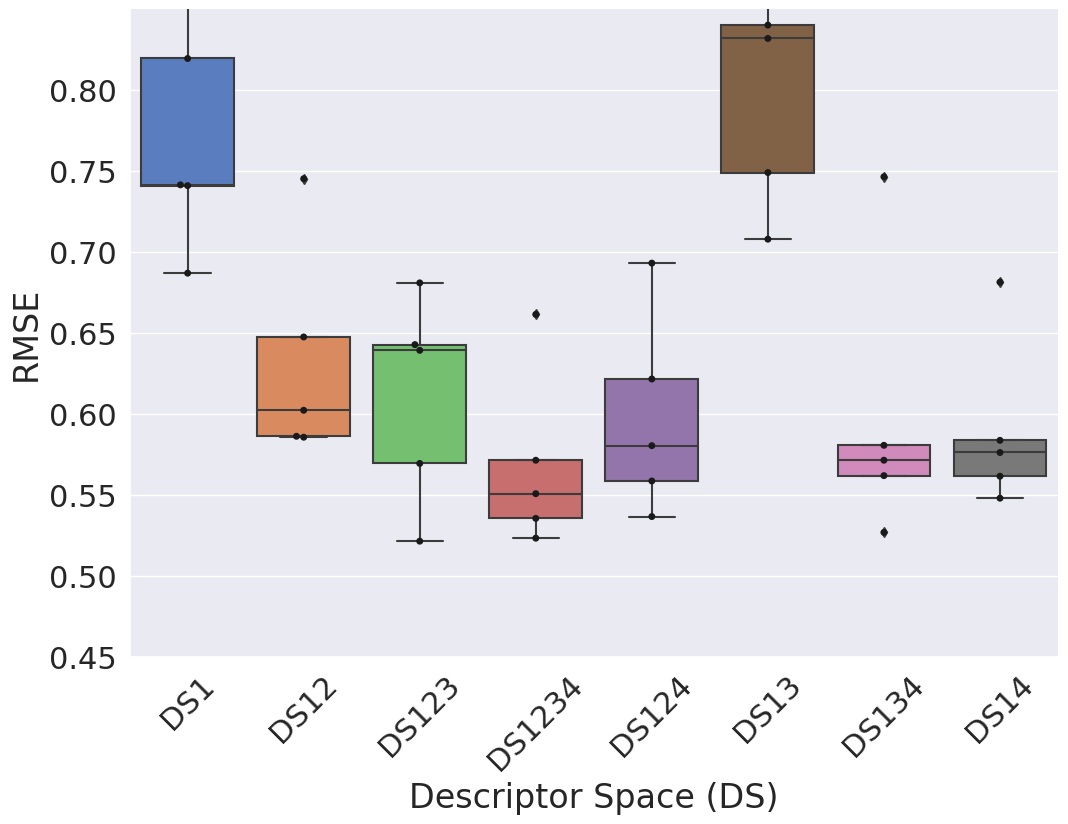

In [36]:
## Zoomed in area (black box)
ANN_outer_test_scores_reduced = ANN_outer_test_scores_pd.loc[:, ANN_outer_test_scores_pd.columns.str.contains('1')]
ANN_outer_test_scores_reduced_long = ANN_outer_test_scores_reduced.melt()
g = sns.catplot(x="variable", y="value", data=ANN_outer_test_scores_reduced_long, kind="box",order=sorted(ANN_outer_test_scores_reduced_long.variable.unique()),palette=sns.color_palette("muted"),height=8,aspect=1.4)
g.map(sns.swarmplot, 'variable', 'value', color='k', order=sorted(ANN_outer_test_scores_reduced_long.variable.unique()))
g.set(xlabel='Descriptor Space (DS)', ylabel='RMSE',title = "",yticks = np.arange(0.45,0.85,0.05))
g.set(ylim=(0.45, 0.85))
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.savefig('../reports/figures/Figure3_bottom_ANN.png', bbox_inches='tight') 

# Random Forest and ANN scatterplots (Figure 4)

In [37]:
def extract_ANN_data_for_plot(ANN_total_data,DS):
    '''
    Function to extract predictions and observations from ANN results.
    Output: Pd dataframe with columns: [nncno, Type (pred/obs), variable (PK), value, Fold]
    
    '''

    scatter_long_pd = pd.DataFrame()
    for i in range(5):

        y_pred = ANN_total_data[DS][i]["output_tensor"].assign(Type = "predictions")
        y_target = ANN_total_data[DS][i]["True_Y"].assign(Type = "observations")
        scatter_long_tmp = pd.concat([y_pred,y_target],axis=0).reset_index().melt(id_vars = ["nncno","Type"]).assign(Fold = i)
        scatter_long_pd = pd.concat([scatter_long_pd,scatter_long_tmp],axis=0)
    return scatter_long_pd
    

<Figure size 640x480 with 0 Axes>

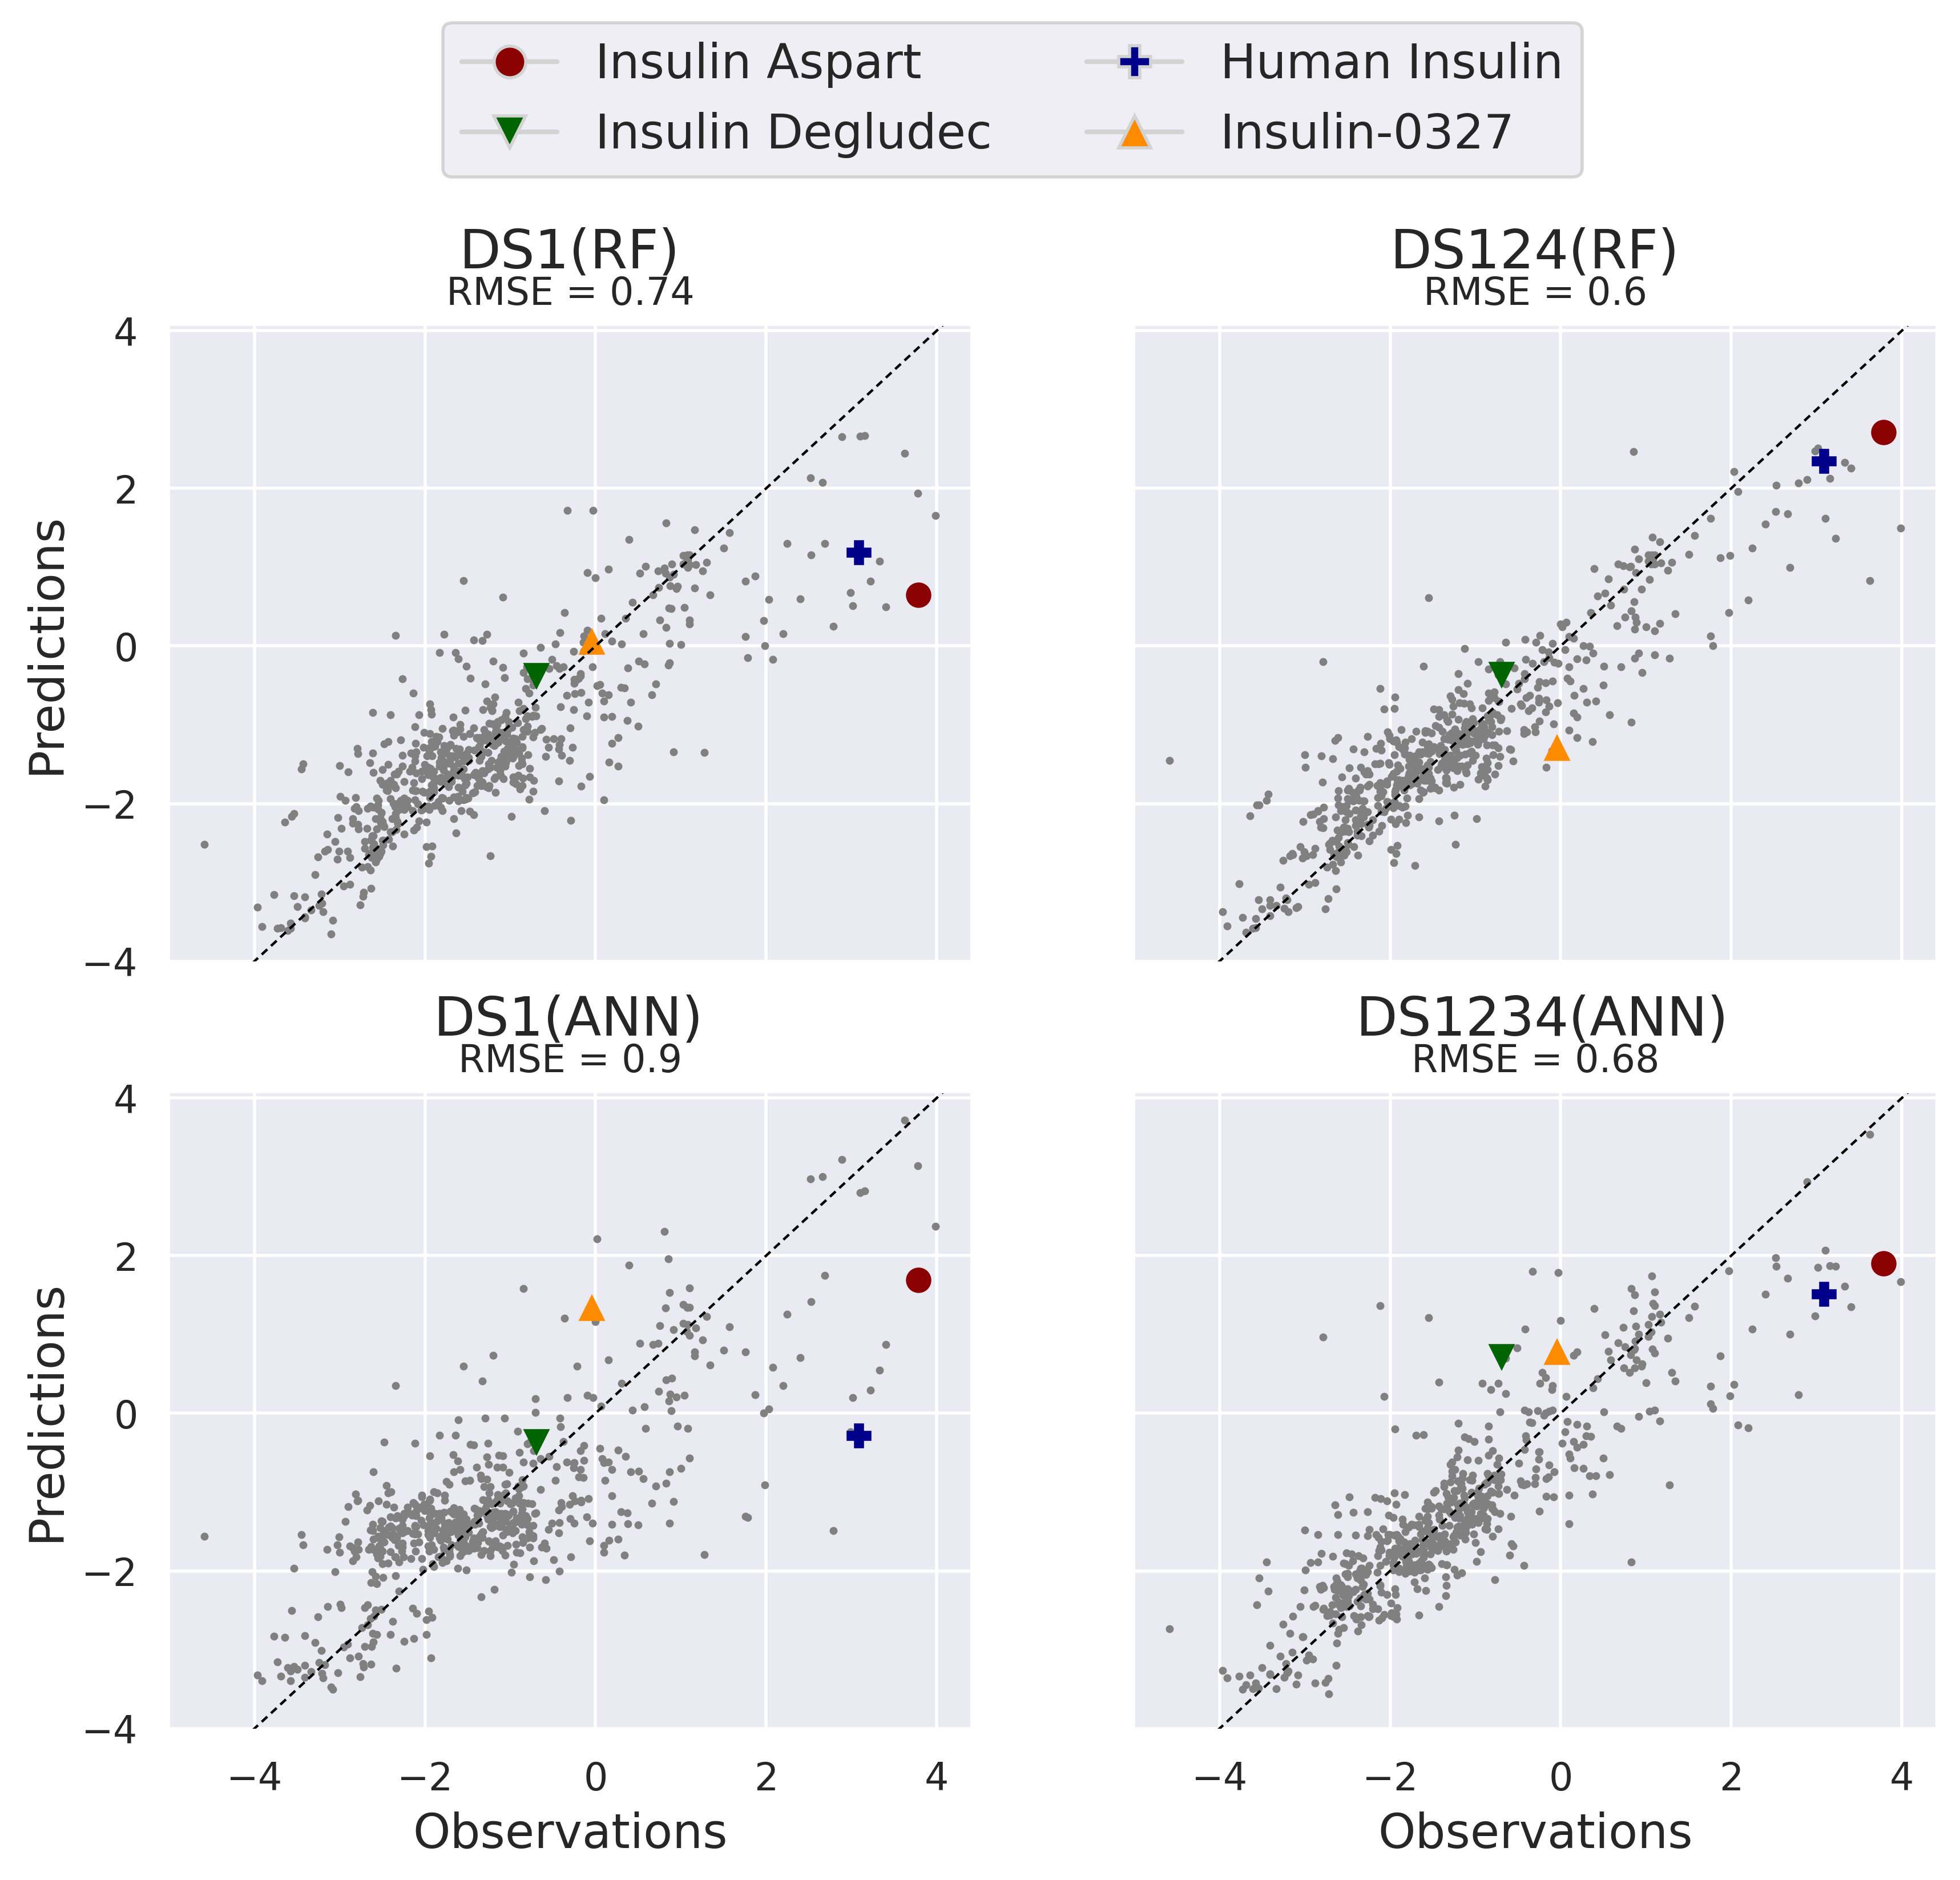

In [38]:
Random_forest_scatter = pickle.load(open('../data/processed/Random_forest_scatter_file.pkl','rb'))
scatter_1 = Random_forest_scatter["DS1"].assign(Model = "DS1(RF)")
scatter_124 = Random_forest_scatter["DS124"].assign(Model = "DS124(RF)")
scatter_random_forest_concat = pd.concat([scatter_1,scatter_124],axis=0)
## Make ANN data:
scatter_1_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1").assign(Model = "DS1(ANN)")
scatter_1234_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1234").assign(Model = "DS1234(ANN)")
scatter_ANN_concat = pd.concat([scatter_1_ANN,scatter_1234_ANN],axis=0)

# Concat to long with both RF and ANN
total_long = pd.concat([scatter_random_forest_concat,scatter_ANN_concat],axis=0)


data_for_t12_plot = total_long[total_long.variable == "CL[ml/min/kg]"].drop(["variable","Fold"],axis=1)
data_for_t12_plot = data_for_t12_plot.pivot(index = ["Model","nncno"],columns = "Type",values = "value").reset_index().set_index("nncno")
data_for_t12_plot["Model_type"] = np.where(data_for_t12_plot.Model.str[-4:] == "(RF)","RF","ANN")

plt.clf()
fig, axs = plt.subplots(2, 2,figsize=(10,8),dpi = 400,sharex=True, sharey=True)
idx_name = ["DS1(RF)","DS124(RF)","DS1(ANN)","DS1234(ANN)"]
kk = 0
RMSE_t12 = np.round(data_for_t12_plot.groupby(["Model"]).apply( r2_rmse ),2).reset_index()
RMSE_t12.set_index("Model",inplace=True)
RMSE_t12 = RMSE_t12.reindex(idx_name)

aspart_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0014"]
degludec_data = data_for_t12_plot[data_for_t12_plot.index == "0100-0000-0454"]
human_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0308"]
LP_data = data_for_t12_plot[data_for_t12_plot.index == "0123-0000-0327"]


for i in range(2):
    for j in range(2):
            axs[i,j].plot(data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["observations"], data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["predictions"],'o',ms=1.5,color = "gray")
            axs[i,j].plot(aspart_data[aspart_data.Model == idx_name[kk]]["observations"], aspart_data[aspart_data.Model == idx_name[kk]]["predictions"],'o',ms=7,color = "darkred")
            axs[i,j].plot(degludec_data[degludec_data.Model == idx_name[kk]]["observations"], degludec_data[degludec_data.Model == idx_name[kk]]["predictions"],'v',ms=7,color = "darkgreen")
            axs[i,j].plot(human_data[human_data.Model == idx_name[kk]]["observations"], human_data[human_data.Model == idx_name[kk]]["predictions"],'P',ms=7,color = "darkblue")
            axs[i,j].plot(LP_data[LP_data.Model == idx_name[kk]]["observations"], LP_data[LP_data.Model == idx_name[kk]]["predictions"],'^',ms=7,color = "darkorange")
            
            axs[i,j].axline((1, 1), slope=1,color="black", dashes=(3, 2),linewidth=0.8)
            axs[i,j].set_title("RMSE = {RMSE}".format(RMSE =round(RMSE_t12.iloc[kk,0],2)),fontsize=12)
            axs[i,j].tick_params(axis='both', which='major', labelsize=12) 
            #xlabel("X axis label")
            #fig[i,j].ylabel("Y axis label")
            
            kk = kk +1 
           
axs[0,0].text(-1.6, 4.8,'DS1(RF)', fontsize=17)
axs[0,1].text(-2, 4.8,'DS124(RF)', fontsize=17)
axs[1,0].text(-1.9, 4.8,'DS1(ANN)', fontsize=17)
axs[1,1].text(-2.4, 4.8,'DS1234(ANN)', fontsize=17)


axs[0,0].set_ylabel('Predictions', fontsize=15)
axs[1,0].set_ylabel('Predictions', fontsize=15)
axs[1,1].set_xlabel('Observations', fontsize=15)
axs[1,0].set_xlabel('Observations', fontsize=15)

legend_elements = [Line2D([0], [0], marker='o', color = "lightgray", label='Insulin Aspart',markersize = 10,markerfacecolor = "darkred"),
                   Line2D([0], [0], marker='v', color='lightgray', label='Insulin Degludec', markersize=10,markerfacecolor = "darkgreen"),
                   Line2D([0], [0], marker='P', color='lightgray', label='Human Insulin', markersize=10,markerfacecolor = "darkblue"),
                   Line2D([0], [0], marker='^', color='lightgray', label='Insulin-0327', markersize=10,markerfacecolor = "darkorange", )
                   
                  ]
axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(-0.15, 2.55), ncol=2,prop={'size': 15})
#axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(1.55, 1))

plt.savefig("../reports/figures/Figure5_CL_scatter.png",bbox_inches = 'tight') 

<Figure size 640x480 with 0 Axes>

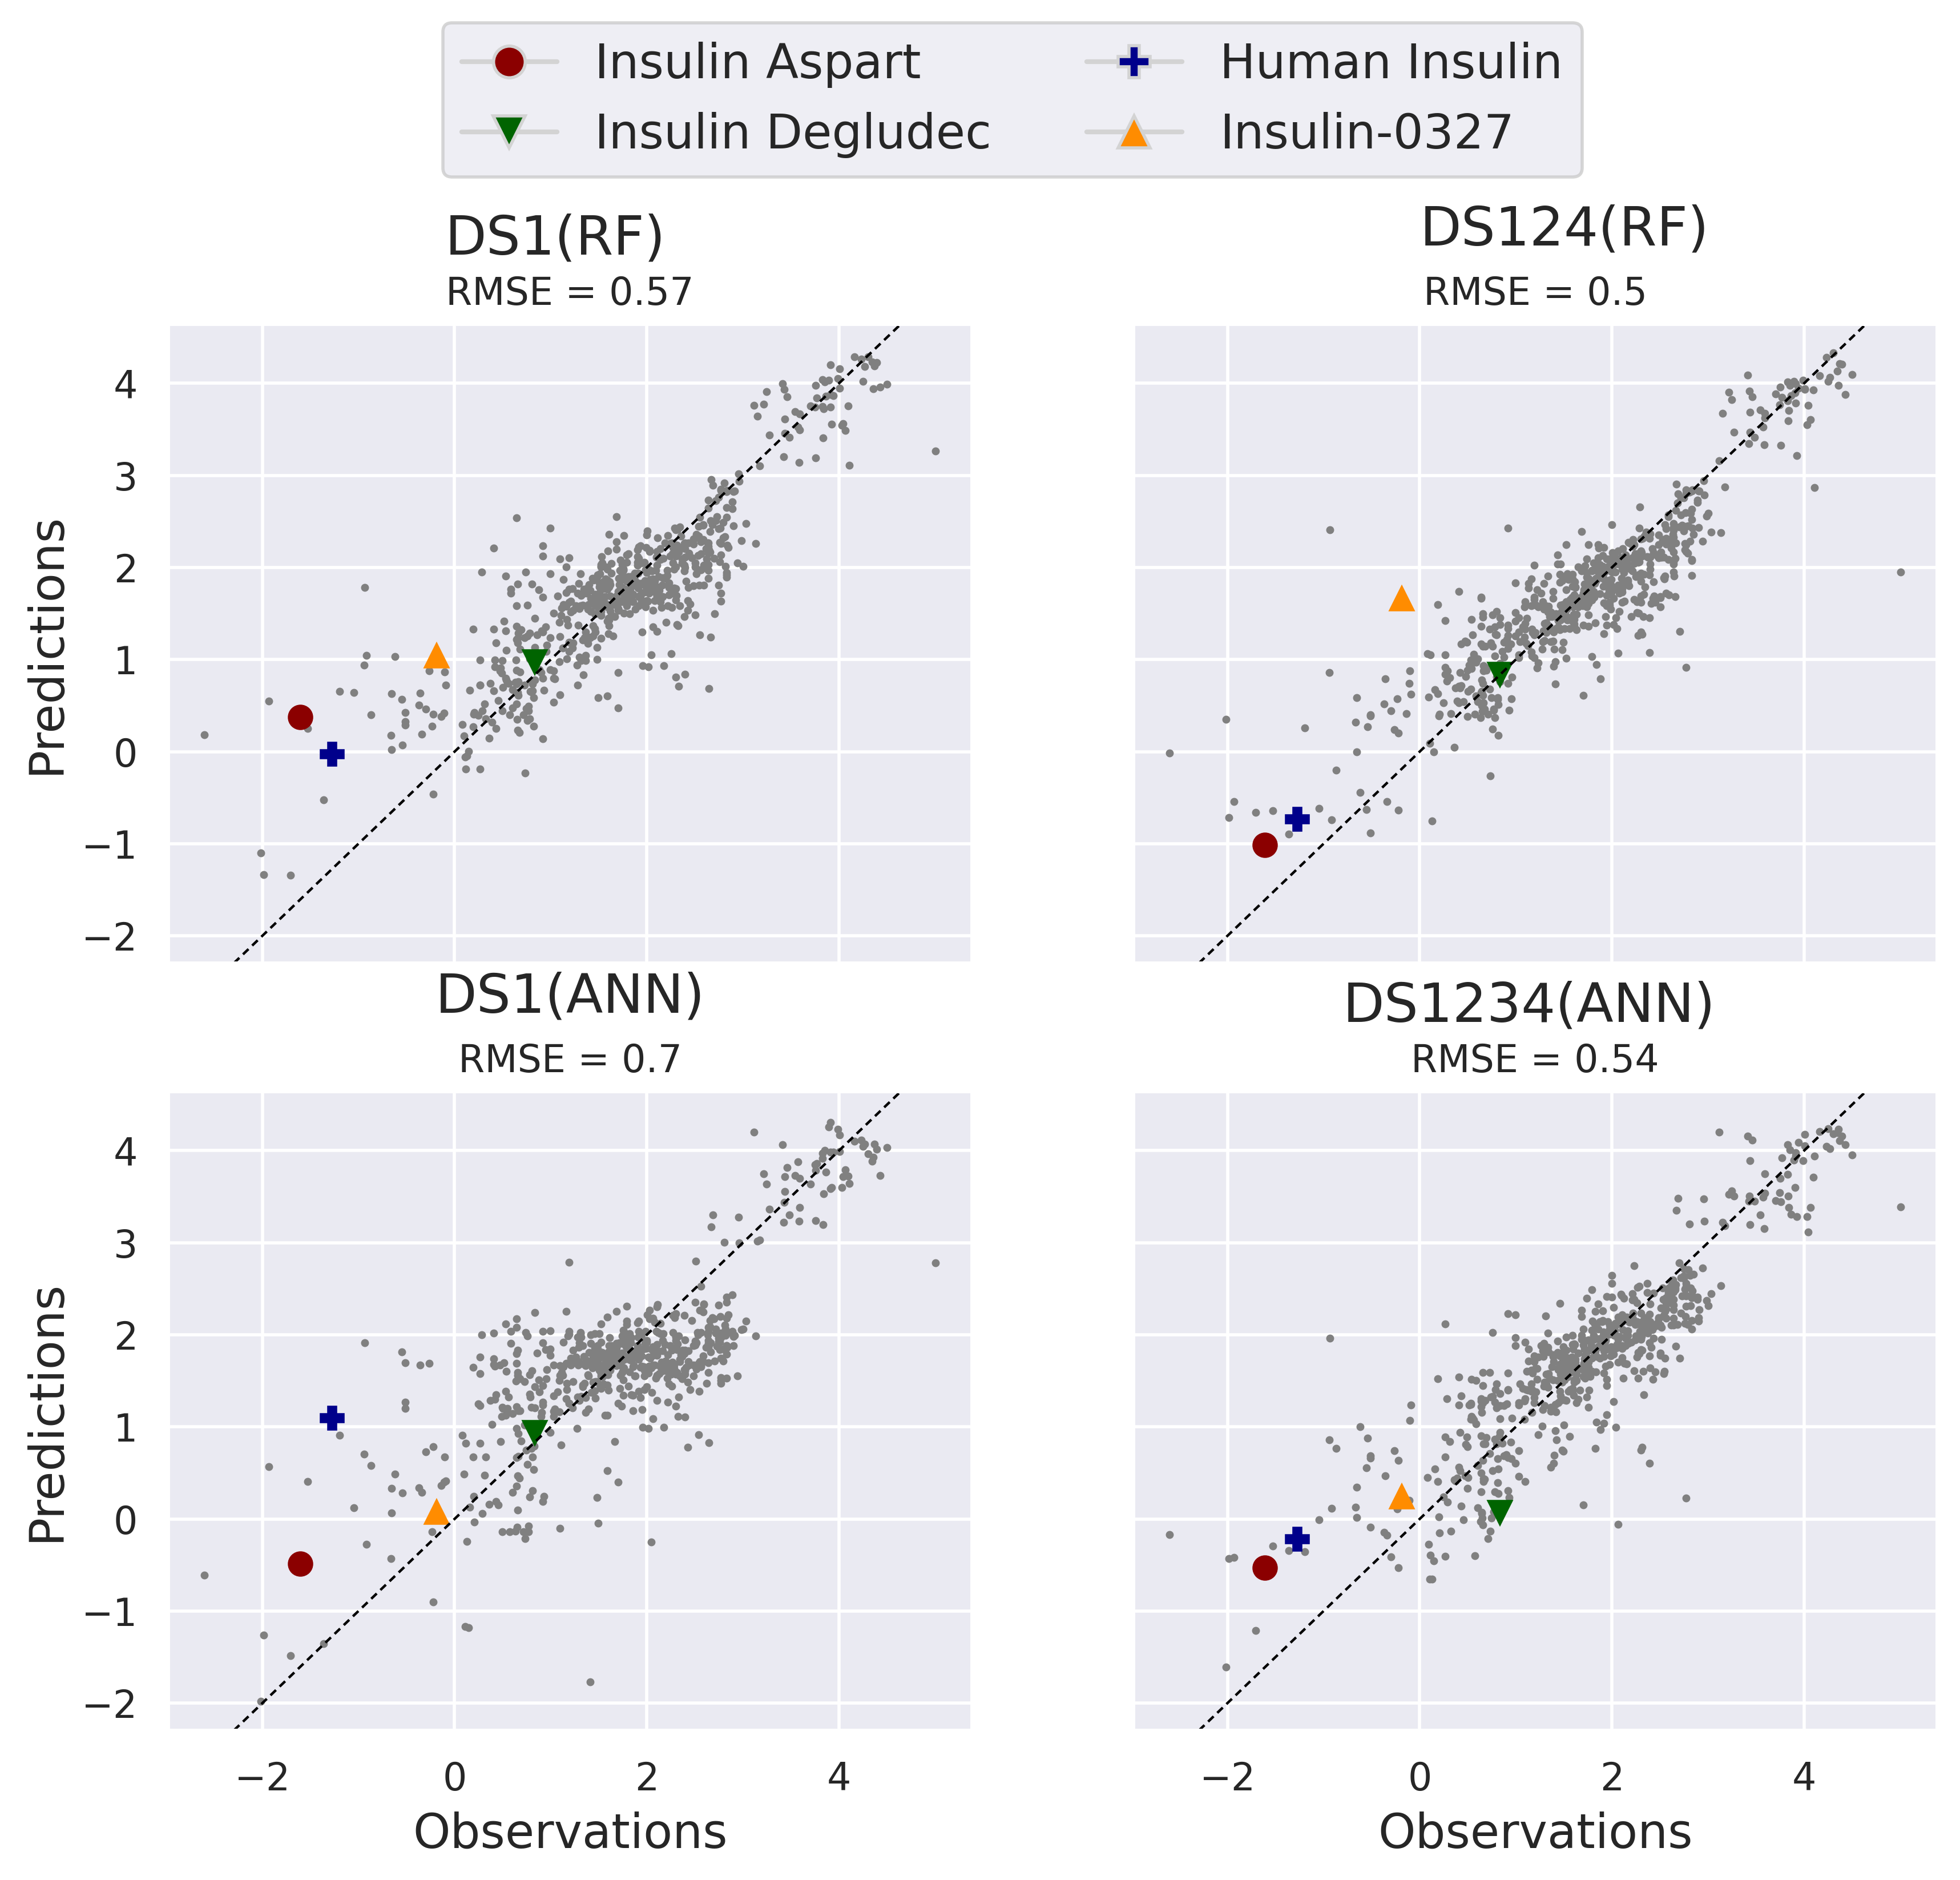

In [39]:
# T1/2
Random_forest_scatter = pickle.load(open('../data/processed/Random_forest_scatter_file.pkl','rb'))
scatter_1 = Random_forest_scatter["DS1"].assign(Model = "DS1(RF)")
scatter_124 = Random_forest_scatter["DS124"].assign(Model = "DS124(RF)")
scatter_random_forest_concat = pd.concat([scatter_1,scatter_124],axis=0)
## Make ANN data:
scatter_1_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1").assign(Model = "DS1(ANN)")
scatter_1234_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1234").assign(Model = "DS1234(ANN)")
scatter_ANN_concat = pd.concat([scatter_1_ANN,scatter_1234_ANN],axis=0)

# Concat to long with both RF and ANN
total_long = pd.concat([scatter_random_forest_concat,scatter_ANN_concat],axis=0)


data_for_t12_plot = total_long[total_long.variable == "T1/2[h]"].drop(["variable","Fold"],axis=1)
data_for_t12_plot = data_for_t12_plot.pivot(index = ["Model","nncno"],columns = "Type",values = "value").reset_index().set_index("nncno")
data_for_t12_plot["Model_type"] = np.where(data_for_t12_plot.Model.str[-4:] == "(RF)","RF","ANN")

plt.clf()
fig, axs = plt.subplots(2, 2,figsize=(10,8),dpi = 400,sharex=True, sharey=True)
idx_name = ["DS1(RF)","DS124(RF)","DS1(ANN)","DS1234(ANN)"]
kk = 0
RMSE_t12 = np.round(data_for_t12_plot.groupby(["Model"]).apply( r2_rmse ),2).reset_index()
RMSE_t12.set_index("Model",inplace=True)
RMSE_t12 = RMSE_t12.reindex(idx_name)

aspart_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0014"]
degludec_data = data_for_t12_plot[data_for_t12_plot.index == "0100-0000-0454"]
human_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0308"]
LP_data = data_for_t12_plot[data_for_t12_plot.index == "0123-0000-0327"]


for i in range(2):
    for j in range(2):
            axs[i,j].plot(data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["observations"], data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["predictions"],'o',ms=1.5,color = "gray")
            axs[i,j].plot(aspart_data[aspart_data.Model == idx_name[kk]]["observations"], aspart_data[aspart_data.Model == idx_name[kk]]["predictions"],'o',ms=7,color = "darkred")
            axs[i,j].plot(degludec_data[degludec_data.Model == idx_name[kk]]["observations"], degludec_data[degludec_data.Model == idx_name[kk]]["predictions"],'v',ms=7,color = "darkgreen")
            axs[i,j].plot(human_data[human_data.Model == idx_name[kk]]["observations"], human_data[human_data.Model == idx_name[kk]]["predictions"],'P',ms=7,color = "darkblue")
            axs[i,j].plot(LP_data[LP_data.Model == idx_name[kk]]["observations"], LP_data[LP_data.Model == idx_name[kk]]["predictions"],'^',ms=7,color = "darkorange")
            
            axs[i,j].axline((1, 1), slope=1,color="black", dashes=(3, 2),linewidth=0.8)
            axs[i,j].set_title("RMSE = {RMSE}".format(RMSE =round(RMSE_t12.iloc[kk,0],2)),fontsize=12)
            axs[i,j].tick_params(axis='both', which='major', labelsize=12) 
            #xlabel("X axis label")
            #fig[i,j].ylabel("Y axis label")
            
            kk = kk +1 
           
axs[0,0].text(-0.1, 5.4,'DS1(RF)', fontsize=17)
axs[0,1].text(0, 5.5,'DS124(RF)', fontsize=17)
axs[1,0].text(-0.2, 5.5,'DS1(ANN)', fontsize=17)
axs[1,1].text(-0.8, 5.4,'DS1234(ANN)', fontsize=17)


axs[0,0].set_ylabel('Predictions', fontsize=15)
axs[1,0].set_ylabel('Predictions', fontsize=15)
axs[1,1].set_xlabel('Observations', fontsize=15)
axs[1,0].set_xlabel('Observations', fontsize=15)

legend_elements = [Line2D([0], [0], marker='o', color = "lightgray", label='Insulin Aspart',markersize = 10,markerfacecolor = "darkred"),
                   Line2D([0], [0], marker='v', color='lightgray', label='Insulin Degludec', markersize=10,markerfacecolor = "darkgreen"),
                   Line2D([0], [0], marker='P', color='lightgray', label='Human Insulin', markersize=10,markerfacecolor = "darkblue"),
                   Line2D([0], [0], marker='^', color='lightgray', label='Insulin-0327', markersize=10,markerfacecolor = "darkorange", )
                   
                  ]
axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(-0.15, 2.55), ncol=2,prop={'size': 15})
#axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(1.55, 1))

plt.savefig("../reports/figures/Figure5_T12[h]_scatter.png",bbox_inches = 'tight') 

<Figure size 640x480 with 0 Axes>

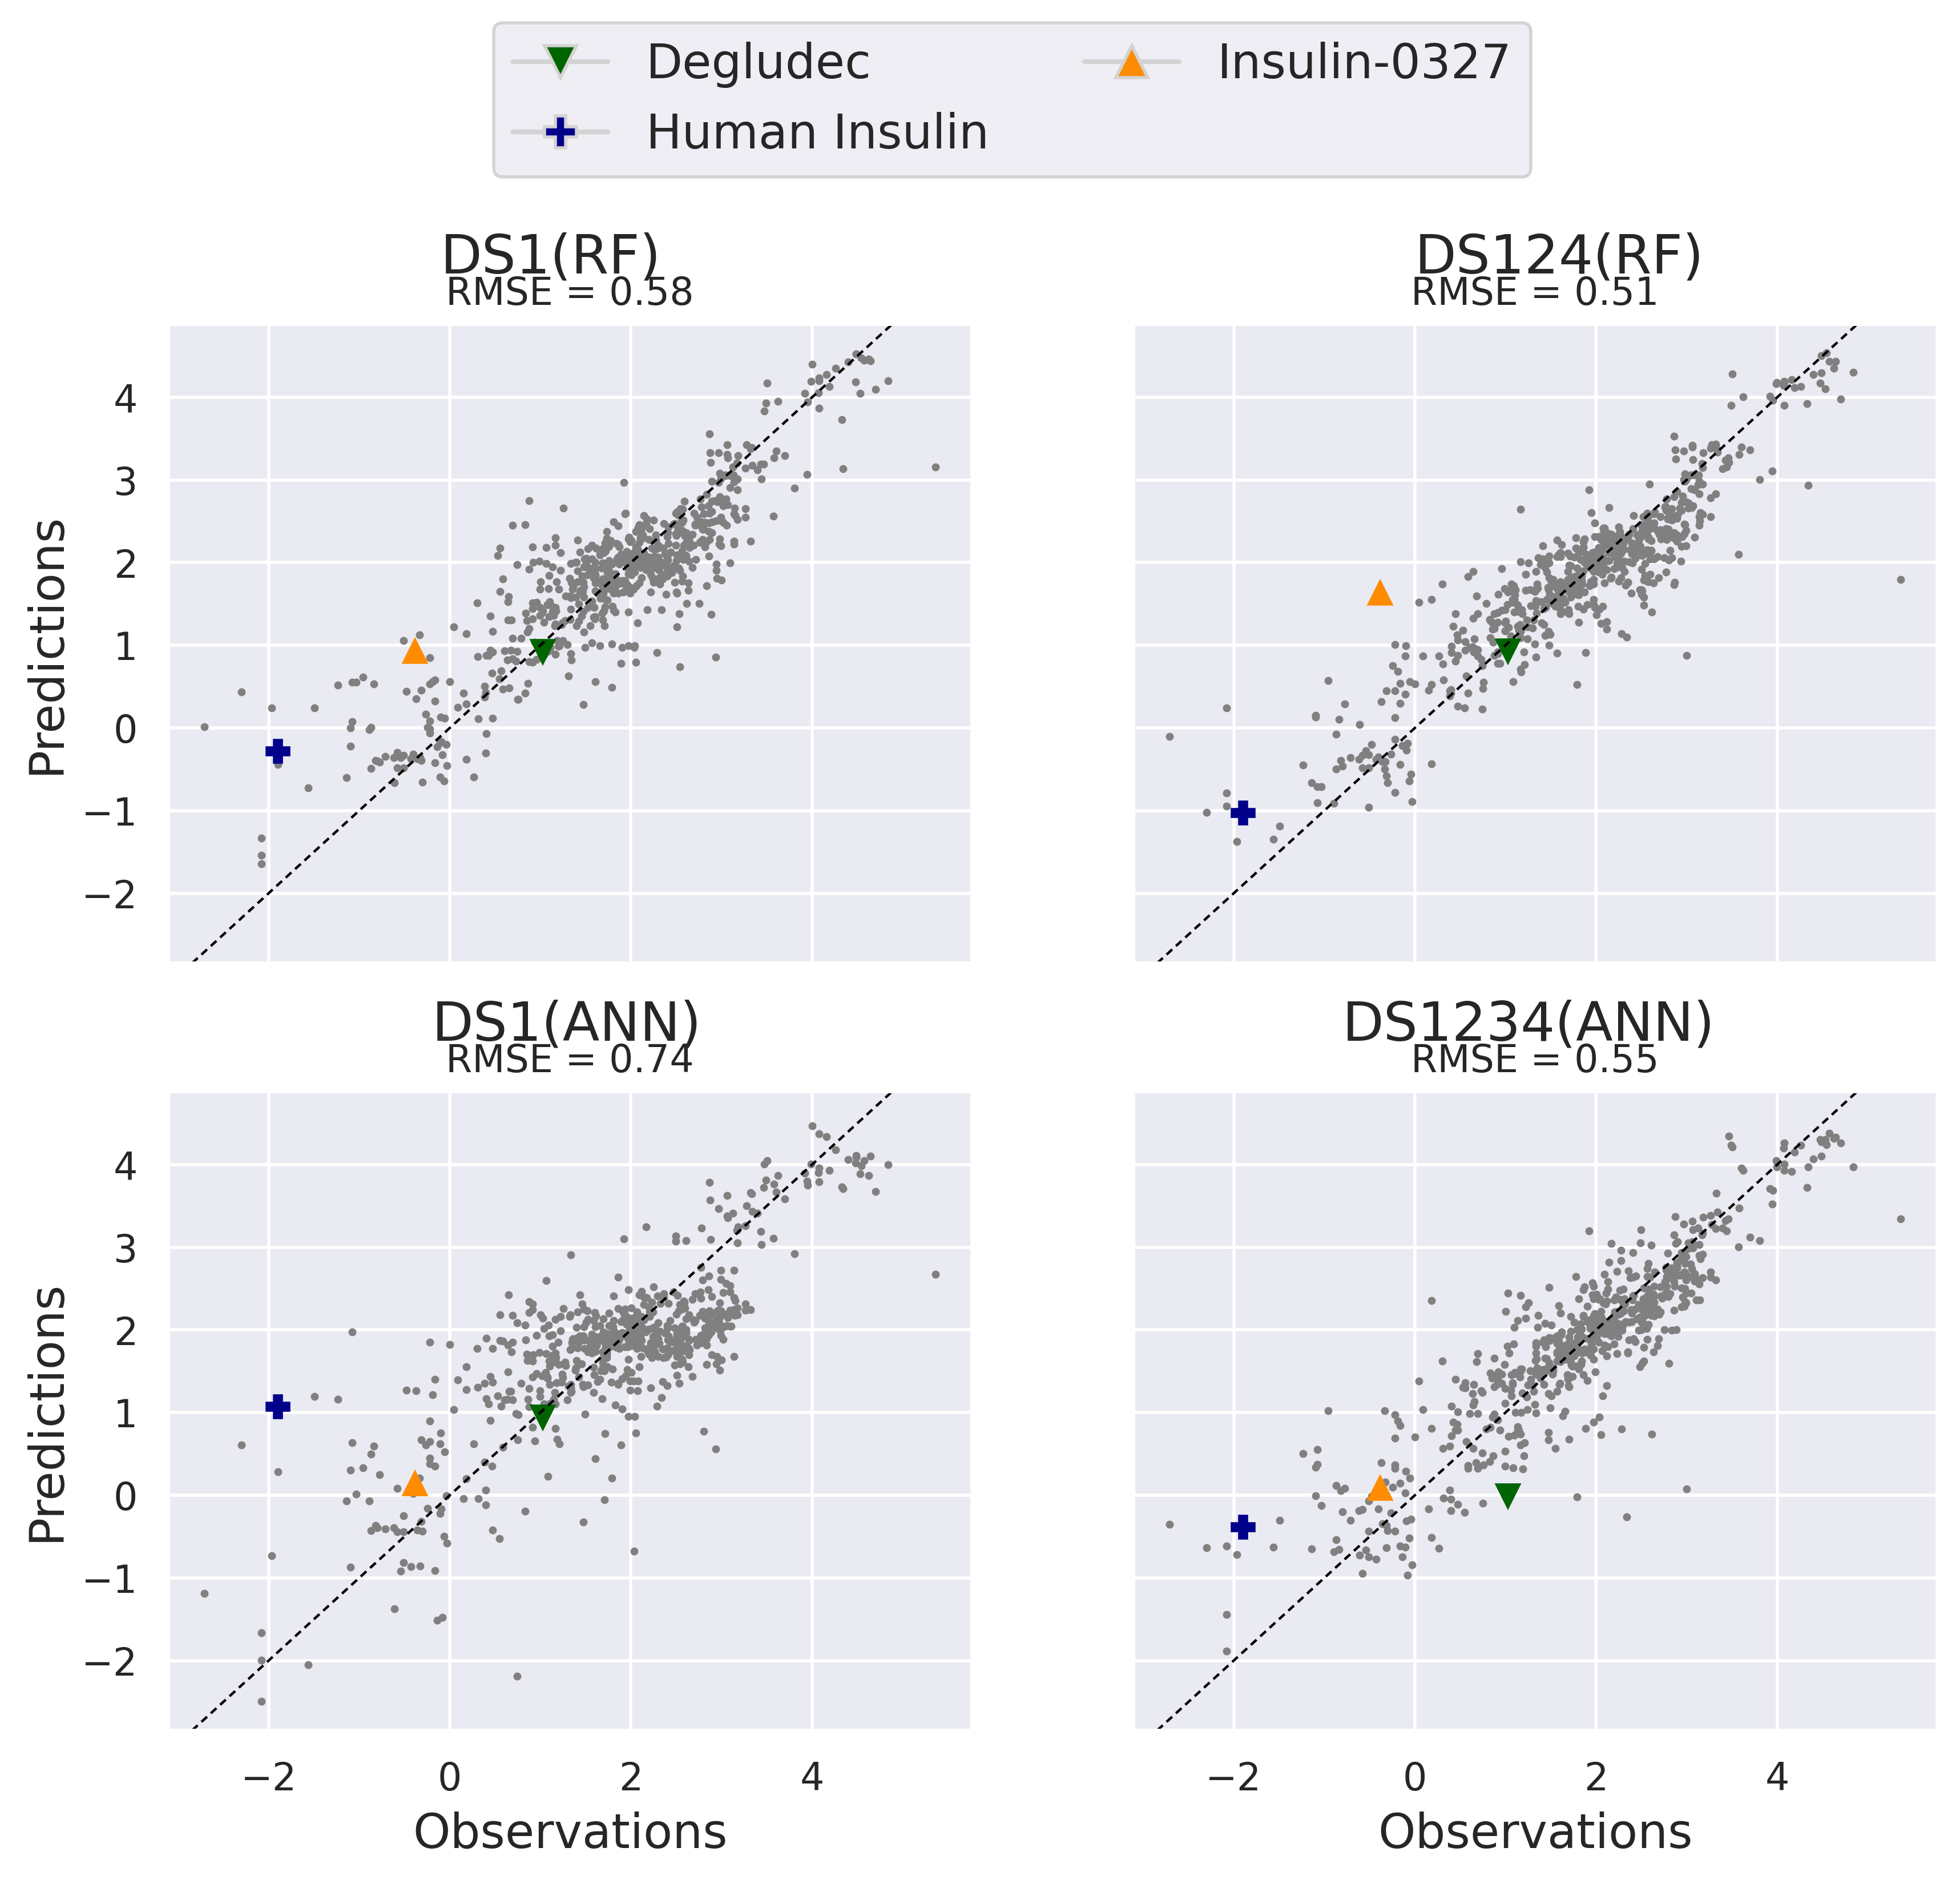

In [40]:
# MRT
Random_forest_scatter = pickle.load(open('../data/processed/Random_forest_scatter_file.pkl','rb'))
scatter_1 = Random_forest_scatter["DS1"].assign(Model = "DS1(RF)")
scatter_124 = Random_forest_scatter["DS124"].assign(Model = "DS124(RF)")
scatter_random_forest_concat = pd.concat([scatter_1,scatter_124],axis=0)
## Make ANN data:
scatter_1_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1").assign(Model = "DS1(ANN)")
scatter_1234_ANN = extract_ANN_data_for_plot(ANN_total_data,"DS1234").assign(Model = "DS1234(ANN)")
scatter_ANN_concat = pd.concat([scatter_1_ANN,scatter_1234_ANN],axis=0)

# Concat to long with both RF and ANN
total_long = pd.concat([scatter_random_forest_concat,scatter_ANN_concat],axis=0)


data_for_t12_plot = total_long[total_long.variable == "MRT[h]"].drop(["variable","Fold"],axis=1)
data_for_t12_plot = data_for_t12_plot.pivot(index = ["Model","nncno"],columns = "Type",values = "value").reset_index().set_index("nncno")
data_for_t12_plot["Model_type"] = np.where(data_for_t12_plot.Model.str[-4:] == "(RF)","RF","ANN")

plt.clf()
fig, axs = plt.subplots(2, 2,figsize=(10,8),dpi = 400,sharex=True, sharey=True)
idx_name = ["DS1(RF)","DS124(RF)","DS1(ANN)","DS1234(ANN)"]
kk = 0
RMSE_t12 = np.round(data_for_t12_plot.groupby(["Model"]).apply( r2_rmse ),2).reset_index()
RMSE_t12.set_index("Model",inplace=True)
RMSE_t12 = RMSE_t12.reindex(idx_name)

#aspart_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0014"]
degludec_data = data_for_t12_plot[data_for_t12_plot.index == "0100-0000-0454"]
human_data = data_for_t12_plot[data_for_t12_plot.index == "0121-0000-0308"]
LP_data = data_for_t12_plot[data_for_t12_plot.index == "0123-0000-0327"]


for i in range(2):
    for j in range(2):
            axs[i,j].plot(data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["observations"], data_for_t12_plot[data_for_t12_plot.Model == idx_name[kk]]["predictions"],'o',ms=1.5,color = "gray")
            axs[i,j].plot(degludec_data[degludec_data.Model == idx_name[kk]]["observations"], degludec_data[degludec_data.Model == idx_name[kk]]["predictions"],'v',ms=7,color = "darkgreen")
            axs[i,j].plot(human_data[human_data.Model == idx_name[kk]]["observations"], human_data[human_data.Model == idx_name[kk]]["predictions"],'P',ms=7,color = "darkblue")
            axs[i,j].plot(LP_data[LP_data.Model == idx_name[kk]]["observations"], LP_data[LP_data.Model == idx_name[kk]]["predictions"],'^',ms=7,color = "darkorange")
            
            axs[i,j].axline((1, 1), slope=1,color="black", dashes=(3, 2),linewidth=0.8)
            axs[i,j].set_title("RMSE = {RMSE}".format(RMSE =round(RMSE_t12.iloc[kk,0],2)),fontsize=12)
            axs[i,j].tick_params(axis='both', which='major', labelsize=12) 
            #xlabel("X axis label")
            #fig[i,j].ylabel("Y axis label")
            
            kk = kk +1 
           
axs[0,0].text(-0.1, 5.5,'DS1(RF)', fontsize=17)
axs[0,1].text(-0, 5.5,'DS124(RF)', fontsize=17)
axs[1,0].text(-0.2, 5.5,'DS1(ANN)', fontsize=17)
axs[1,1].text(-0.8, 5.5,'DS1234(ANN)', fontsize=17)


axs[0,0].set_ylabel('Predictions', fontsize=15)
axs[1,0].set_ylabel('Predictions', fontsize=15)
axs[1,1].set_xlabel('Observations', fontsize=15)
axs[1,0].set_xlabel('Observations', fontsize=15)

legend_elements = [
                   Line2D([0], [0], marker='v', color='lightgray', label='Degludec', markersize=10,markerfacecolor = "darkgreen"),
                   Line2D([0], [0], marker='P', color='lightgray', label='Human Insulin', markersize=10,markerfacecolor = "darkblue"),
                   Line2D([0], [0], marker='^', color='lightgray', label='Insulin-0327', markersize=10,markerfacecolor = "darkorange", )
                   
                  ]
axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(-0.15, 2.55), ncol=2,prop={'size': 15})
#axs[1][1].legend(handles=legend_elements,loc = "center",bbox_to_anchor=(1.55, 1))

plt.savefig("../reports/figures/Figure5_MRT_scatter.png",bbox_inches = 'tight') 

# Paired t-test results

In [19]:

def paired_t_test_values(data_pd):
    '''
    Calculate paired t_test values
    input:
        - data_pd: Pandas dataframe with outer test results for each descriptor in the columns
    output:
        - t_test_matrix: All combinations of pairs of descriptors and their t test value.
    '''
    
    
    Number_descriptors = data_pd.shape[1]
    t_test_matrix = pd.DataFrame(np.zeros((Number_descriptors, Number_descriptors)))
    for i in range(Number_descriptors):
        for j in range(Number_descriptors):
            t_test_matrix.iloc[i,j] = stats.ttest_rel(data_pd.iloc[:,i], data_pd.iloc[:,j])[1]
    
    t_test_matrix.columns = data_pd.columns
    t_test_matrix.index =data_pd.columns

    return t_test_matrix

def plot_t_test_values(dat_to_plot,title = None):
    '''
    Plot t-test scores for quick overview
    
    '''
    
    mask = np.zeros_like(dat_to_plot)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 10))
        RF_sns = sns.heatmap(round(dat_to_plot,2), cmap='Blues_r', annot=True, 
            annot_kws={"size": 15}, vmin=0, vmax=1,mask=mask)
        ax.set_title(title)

        
def paired_t_test_across_model(RF_data,ANN_data):
    
    Number_descriptors = RF_data.shape[1]
    t_test_vector = pd.Series(np.zeros((Number_descriptors)))
    
    for i in range(Number_descriptors):
            t_test_vector.iloc[i] = stats.ttest_rel(RF_data.iloc[:,i], ANN_data.iloc[:,i])[1]
    
    return t_test_vector
    
        

## Calculate paired t-test and visualize in heatmap on Random Forest
t_test_scores_RF = paired_t_test_values(Random_forest_outer_test_scores_reduced)
#plot_t_test_values(t_test_scores_RF,"Paired t-test for Random Forest models")

## Calculate paired t-test and visualize in heatmap on ANN
t_test_scores_ANN = paired_t_test_values(ANN_outer_test_scores_reduced)
#plot_t_test_values(t_test_scores_ANN,"Paired t-test for ANN models")

# Calculate the paired t-test difference between model on same descriptorsets
t_test_diff = paired_t_test_across_model(Random_forest_outer_test_scores_reduced,ANN_outer_test_scores_reduced)
pd.DataFrame([Random_forest_outer_test_scores_reduced.columns,t_test_diff]).T
#pd.DataFrame(t_test_diff)

,0,1
0,DS1,0.029774
1,DS12,0.026936
2,DS123,0.318357
3,DS1234,0.650851
4,DS124,0.209526
5,DS134,0.298514
6,DS14,0.199471
7,DS13,0.003414


# BH corrected p values

In [20]:
def calculate_BH(t_test_scores_RF,index):
    '''
    Calculate BH threshold for input T-test matrix. 
    Input:
    
    - t_test_scores_RF: DataFrame og t-test across all tested models (NxN)
    
    - index: Index of which columns (descriptor set) to compare to the rest of the descriptor sets 
    
    output:
    - eval_pval: Matrix of p value, rank and BH value
    - eval_pd: Dataframe of significant descriptorsets
    
    '''
    
    
    t_test_scores_RF_BH = t_test_scores_RF.drop(t_test_scores_RF.iloc[index].name).iloc[:,index].reset_index().drop("index",axis=1)
    BH_ranks = pd.DataFrame(rankdata(t_test_scores_RF_BH),columns= ["Rank"])
    t_test_scores_RF_BH_for_index = t_test_scores_RF.drop(t_test_scores_RF.iloc[index].name).iloc[:,index].sort_values().index

    BH_values = pd.DataFrame(rankdata(t_test_scores_RF_BH)/7*0.05,columns= ["BH_value"])
    eval_pval = pd.concat([t_test_scores_RF_BH,BH_ranks,BH_values],axis=1).sort_values(by = "Rank").set_index(t_test_scores_RF_BH_for_index)

    eval_pd = eval_pval[eval_pval[t_test_scores_RF.columns[index]] < eval_pval["BH_value"]]
    
    return eval_pval , eval_pd

In [ ]:
t_test_scores_RF

In [ ]:
calculate_BH(t_test_scores_RF,0)

In [ ]:
calculate_BH(t_test_scores_ANN,6)

In [ ]:
sns.set_theme(style="white")

t_test_RF = t_test_scores_RF
t_test_ANN = t_test_scores_ANN
mask_RF= np.tril(np.ones_like(t_test_RF, dtype=bool))
mask_ANN = np.triu(np.ones_like(t_test_ANN, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(t_test_RF, mask=mask_RF, cmap='Blues', vmax=1, vmin=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .85, "pad":-.01}, ax=ax,annot=True)

#flare
sns.heatmap(t_test_ANN, mask=mask_ANN, cmap='flare', vmax=1, vmin=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .85}, ax=ax,annot=True)
# Manually:
# the following lines color and hatch the axes background, only the diagonals are visible
ax.patch.set_facecolor('darkgrey')
#ax.patch.set_edgecolor('yellow')
#ax.patch.set_hatch('xx')
ax.set_title('P values from paired t-tests',fontsize=15)
ax.text(8.3, -0.15,'ANN', fontsize=17)
ax.text(9.9, -0.15,'RF', fontsize=17)


ax.add_patch(Rectangle((4,0),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((2,1),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((7,1),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((4,2),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((7,3),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((7,4),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((7,5),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((7,6),1,1, fill=False, edgecolor='black', lw=4))


ax.add_patch(Rectangle((0,1),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((0,2),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((0,3),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((0,4),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((0,5),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((0,6),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((1,4),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((1,6),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((1,7),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((3,7),1,1, fill=False, edgecolor='black', lw=4))
#ax.add_patch(Rectangle((3,6),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((4,7),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((5,7),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((6,7),1,1, fill=False, edgecolor='black', lw=4))
ax.add_patch(Rectangle((1,3),1,1, fill=False, edgecolor='black', lw=4))

# Check boxes before exporting
#plt.savefig("../reports/figures/Figure4.png",bbox_inches = 'tight') 

# SHAP plot (Figure 5)

In [18]:
# See "Random Forest.py" script

# Data for table 1

In [26]:
Data_with_groups = pd.read_excel("../data/raw/Data_with_groups.xlsx")
Data_with_groups.rename(columns={"NNCNo": "nncno"})
Data_with_groups.set_index("NNCNo",inplace=True)
Data_with_groups = Data_with_groups[~Data_with_groups.index.isin(["0148-0000-1247"])]
Full_data = pd.read_csv("../data/processed/full_data_set.csv")
Full_data.set_index("nncno",inplace=True)
PK_names = ["CL[ml/min/kg]","T1/2[h]","MRT[h]"]

In [27]:
Data_with_groups["Groups"].value_counts()

Acylation                   338
Concatenated proteins       154
Antibody attachment (Fc)     60
Other                        44
AA extensions                35
No attachments                9
Name: Groups, dtype: int64

In [28]:
data_wg = pd.merge(Full_data, Data_with_groups["Groups"], left_index=True, right_index=True)

In [29]:
data_wg.groupby(["Groups"])[PK_names].mean()

,CL[ml/min/kg],T1/2[h],MRT[h]
Groups,,,
AA extensions,2.738457,2.148000,1.043143
Acylation,0.437273,7.513562,9.109969
Antibody attachment (Fc),0.062266,47.724288,50.213167
Concatenated proteins,0.260740,6.088125,7.371136
No attachments,23.554508,0.416302,0.337646
Other,7.748170,2.603753,2.159956


In [30]:
data_wg.groupby(["Groups"])[PK_names].min()

,CL[ml/min/kg],T1/2[h],MRT[h]
Groups,,,
AA extensions,0.20000,0.390000,0.290000
Acylation,0.04945,0.393496,0.333333
Antibody attachment (Fc),0.01020,14.440000,6.850000
Concatenated proteins,0.02910,1.520000,1.360000
No attachments,7.62200,0.144828,0.100000
Other,0.12000,0.074074,0.066667


In [31]:
data_wg.groupby(["Groups"])[PK_names].max()

,CL[ml/min/kg],T1/2[h],MRT[h]
Groups,,,
AA extensions,11.000,11.30,6.60
Acylation,5.790,23.00,27.70
Antibody attachment (Fc),0.147,149.31,213.59
Concatenated proteins,2.030,16.66,23.04
No attachments,44.000,0.80,0.80
Other,54.000,13.40,10.36


# End of results